# Stroke prediction project

Purpose of this project is to create a classifier for stroke prediction using scikit-learn.

Dataset used is [Stroke Prediction Dataset](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset) from kaggle.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import itertools
import joblib
from pprint import pprint

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, MinMaxScaler

from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score

from sklearn.metrics import confusion_matrix, f1_score, recall_score
import seaborn as sns

np.set_printoptions(suppress=True, precision=5)
pd.options.display.float_format = '{:.5f}'.format

## Data exploration and preprocessing

First thing is data exploration and identification of data preprocessing needs. 

In [30]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv', sep=',')

In [393]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.00000,0,1,Yes,Private,Urban,228.69000,36.60000,formerly smoked,1
1,51676,Female,61.00000,0,0,Yes,Self-employed,Rural,202.21000,NaN,never smoked,1
2,31112,Male,80.00000,0,1,Yes,Private,Rural,105.92000,32.50000,never smoked,1
3,60182,Female,49.00000,0,0,Yes,Private,Urban,171.23000,34.40000,smokes,1
4,1665,Female,79.00000,1,0,Yes,Self-employed,Rural,174.12000,24.00000,never smoked,1


In [394]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [395]:
data.describe(include='object')

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


In [396]:
# Show unique genders

data.gender.unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [397]:
(data['gender'] == 'Other').sum()

1

In [398]:
# Since there is only one gender label other it is dropped

data = data[data.gender != 'Other']
data.shape

(5109, 12)

In [399]:
# Unique values for all features

df_uniques = pd.DataFrame([[col, len(data[col].unique())] for col in data.columns], columns=['Feature', 'Unique Values']).set_index('Feature')
df_uniques

,Unique Values
Feature,
id,5109
gender,2
age,104
hypertension,2
heart_disease,2
ever_married,2
work_type,5
Residence_type,2
avg_glucose_level,3978


In [400]:
# Get all binary type features

binary_features = list(df_uniques[df_uniques['Unique Values'] == 2].index)
binary_features

['gender',
 'hypertension',
 'heart_disease',
 'ever_married',
 'Residence_type',
 'stroke']

In [401]:
# Get all categorical type features

categorical_features = list(df_uniques[(6 >= df_uniques['Unique Values']) & (df_uniques['Unique Values'] > 2)].index)
categorical_features

['work_type', 'smoking_status']

In [402]:
# Show unique values for all categorical features

print([[i, list(data[i].unique())] for i in categorical_features])

[['work_type', ['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked']], ['smoking_status', ['formerly smoked', 'never smoked', 'smokes', 'Unknown']]]


In [403]:
# Drop all rows that have smoking status as unknown

data = data[data.smoking_status != 'Unknown']
data.shape

(3565, 12)

In [404]:
# Get numerical features by removing categorical and binary features from all feature columns

numeric_features = list(set(data.columns) - set(categorical_features) - set(binary_features))
numeric_features.remove('id')
numeric_features

['bmi', 'age', 'avg_glucose_level']

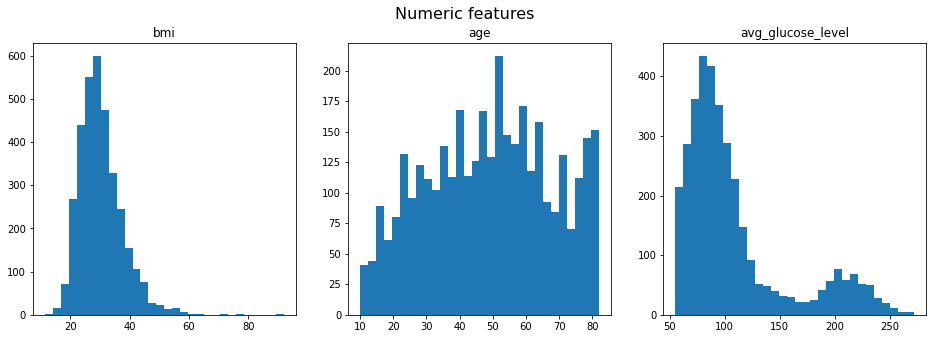

In [406]:
# Show distributions of numerical values.

fig, axs = plt.subplots(1,3, figsize=(16,5))

axlist = axs.flatten()

for ax, feature in zip(axlist, numeric_features):
    ax.hist(data[feature], bins=30)
    ax.set_title(feature)
    
fig.suptitle('Numeric features', fontsize=16)
plt.show()

As can be seen from the above visualizations the bmi and average glucose level features are some what skewed. It is as I have understood common practice to normalize such distributions so the later column transform will include box-cox transofrmation for normalization with scaling.

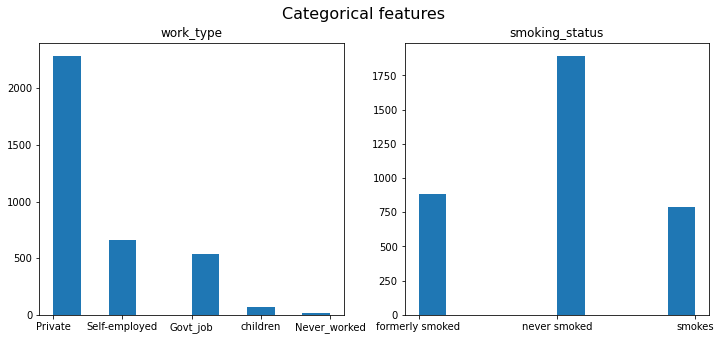

In [407]:
# Distribution of categorical features

fig, axs = plt.subplots(1,2, figsize=(12,5))

axlist = axs.flatten()

for ax, feature in zip(axlist, categorical_features):
    ax.hist(data[feature])
    ax.set_title(feature)
    
fig.suptitle('Categorical features', fontsize=16)
plt.show()

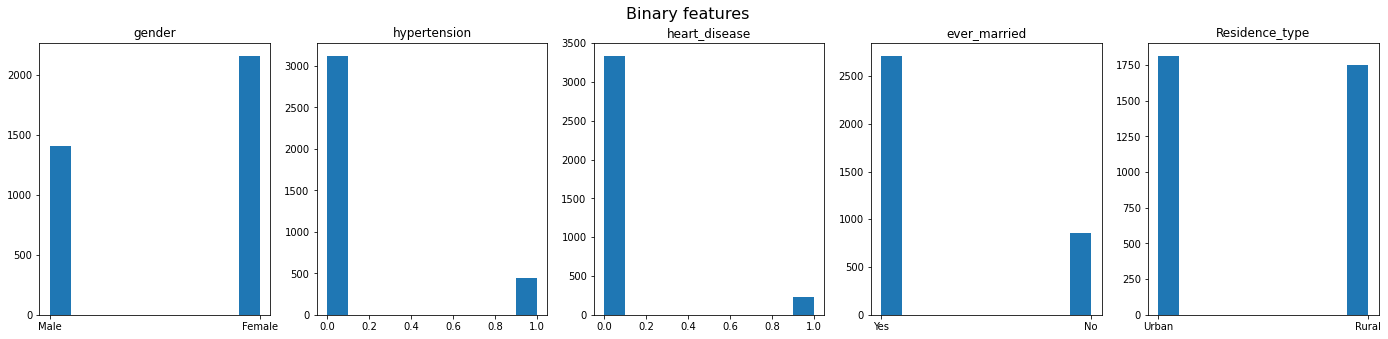

In [408]:
# Distributions of binary features

fig, axs = plt.subplots(1,5, figsize=(24,5))

axlist = axs.flatten()

binary_features = binary_features[:-1]

for ax, feature in zip(axlist, binary_features):
    ax.hist(data[feature])
    ax.set_title(feature)
    
fig.suptitle('Binary features', fontsize=16)
plt.show()

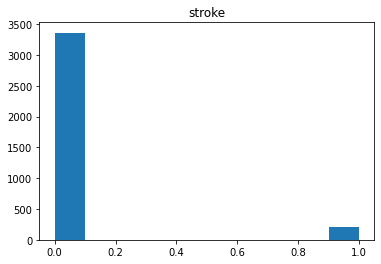

In [409]:
# Distribution of target
# As shown in the plot the distribution is very imbalanced and therefore in the model building section this should be handled

plt.hist(data.stroke)
plt.title('stroke')
plt.show()

In [317]:
joblib.dump(data, 'processed_data')
joblib.dump([numeric_features, categorical_features, binary_features], 'variable_types')

['variable_types']

## Model building

In [10]:
processed_data = joblib.load('processed_data')
numeric_features, categorical_features, binary_features = joblib.load('variable_types')

# Naming convention X=Data y=target

y = processed_data['stroke'].reset_index(drop=True)
X = processed_data[processed_data.columns[:-1]].reset_index(drop=True)
X.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,9046,Male,67.00000,0,1,Yes,Private,Urban,228.69000,36.60000,formerly smoked
1,51676,Female,61.00000,0,0,Yes,Self-employed,Rural,202.21000,NaN,never smoked
2,31112,Male,80.00000,0,1,Yes,Private,Rural,105.92000,32.50000,never smoked
3,60182,Female,49.00000,0,0,Yes,Private,Urban,171.23000,34.40000,smokes
4,1665,Female,79.00000,1,0,Yes,Self-employed,Rural,174.12000,24.00000,never smoked


In [11]:
# Building a column transformer that imputes, normalizes and scales the numerical features and one hot encodes the categorical and binary features

num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('normalizer', PowerTransformer(method='box-cox')),
                           ])

cat_transformer = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))])

col_transformer = ColumnTransformer([('num_processing', num_transformer, numeric_features),
                                     ('cat_processing', cat_transformer, (categorical_features+binary_features))], remainder='passthrough')

### Column transformer test

This section show how the column transformer transform the dataset and what the later classifier will be given as input.

In [12]:
test_data_trans = col_transformer.fit_transform(X)

In [13]:
transformed_cat_cols = col_transformer.named_transformers_['cat_processing'][0].get_feature_names_out(categorical_features+binary_features)

In [14]:
test_dataframe_trans = pd.DataFrame(test_data_trans, columns=[numeric_features+transformed_cat_cols.tolist()+['id']])
transfomed_columns = test_dataframe_trans.columns.get_level_values(0).to_list()
transfomed_columns
test_dataframe_trans.head()

,bmi,age,avg_glucose_level,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_never smoked,smoking_status_smokes,gender_Male,hypertension_1,heart_disease_1,ever_married_Yes,Residence_type_Urban,id
0,0.97472,0.95832,1.77493,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,1.00000,1.00000,9046.00000
1,-0.01634,0.65189,1.61510,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,51676.00000
2,0.47175,1.61274,0.33927,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,1.00000,0.00000,31112.00000
3,0.71504,0.02911,1.36392,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,1.00000,60182.00000
4,-0.91672,1.56282,1.39121,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1665.00000


In [15]:
test_dataframe_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3565 entries, 0 to 3564
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   (bmi,)                          3565 non-null   float64
 1   (age,)                          3565 non-null   float64
 2   (avg_glucose_level,)            3565 non-null   float64
 3   (work_type_Never_worked,)       3565 non-null   float64
 4   (work_type_Private,)            3565 non-null   float64
 5   (work_type_Self-employed,)      3565 non-null   float64
 6   (work_type_children,)           3565 non-null   float64
 7   (smoking_status_never smoked,)  3565 non-null   float64
 8   (smoking_status_smokes,)        3565 non-null   float64
 9   (gender_Male,)                  3565 non-null   float64
 10  (hypertension_1,)               3565 non-null   float64
 11  (heart_disease_1,)              3565 non-null   float64
 12  (ever_married_Yes,)             35

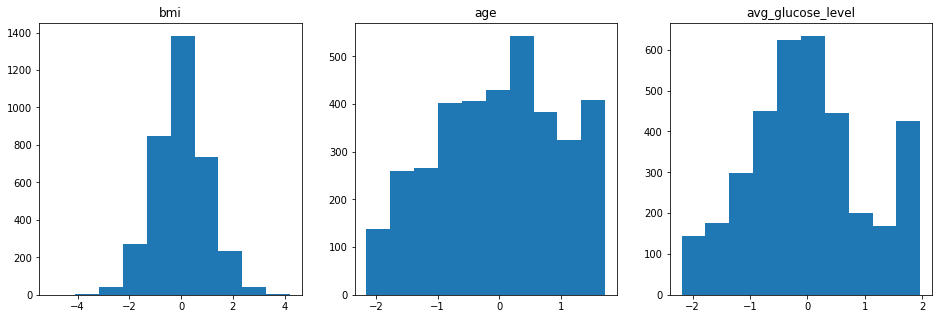

In [16]:
# Normalized and scaled numerical features after column transform

fig, axs = plt.subplots(1,3, figsize=(16,5))

axlist = axs.flatten()

for ax, feature in zip(axlist, numeric_features):
    ax.hist(test_dataframe_trans[feature])
    ax.set_title(feature)

In [17]:
# Split data to train and test sets

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)

train_index, test_index = next(sss.split(X, y))

X_train, X_test = X.loc[train_index], X.loc[test_index]
y_train, y_test = y.loc[train_index], y.loc[test_index]

# Drop id from train set

X_train = X_train.drop(columns=['id'])

# Save test set id such that we can match persons that are later predicted to have a stroke

test_id = X_test.id
X_test = X_test.drop(columns=['id'])

test_id.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2852, 10)
(2852,)
(713, 10)
(713,)


In [18]:
# Show target imbalances

print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

print(y_train.value_counts())
print(y_test.value_counts())

0   0.94320
1   0.05680
Name: stroke, dtype: float64
0   0.94390
1   0.05610
Name: stroke, dtype: float64
0    2690
1     162
Name: stroke, dtype: int64
0    673
1     40
Name: stroke, dtype: int64


In [ ]:
# Get default cross-validation scores for simple classifiers with default parameters without over-sampling

pipes_default = [make_pipeline(col_transformer, LogisticRegression()),
                 make_pipeline(col_transformer, SVC()),
                 make_pipeline(col_transformer, RandomForestClassifier())]

default_scores = {}
for scoring in ['recall', 'f1']:
    for clf in pipes_default:
        scores = cross_val_score(clf, X_train, y_train, cv=10, n_jobs=-1, scoring=scoring, verbose=10)
        default_scores[(scoring, clf[1].__class__.__name__)] = scores
    
joblib.dump(default_scores, 'results/default_scores')

In [20]:
# Show default recall and f1 scores

default_scores = pd.DataFrame(joblib.load('results/default_scores'))

print('Mean recall and F1-scores with standard deviations:')
display(default_scores.agg(['mean', 'std']))

Mean recall and F1-scores with standard deviations:


recall                                                f1  \
     LogisticRegression     SVC RandomForestClassifier LogisticRegression   
mean            0.00625 0.00000                0.00625            0.01176   
std             0.01976 0.00000                0.01976            0.03720   

                                     
         SVC RandomForestClassifier  
mean 0.00000                0.02229  
std  0.00000                0.04708

In [19]:
# Helper function for checking the possible tunable hyperparameter names

def check_params_exist(estimator, params_keyword):
    all_params = estimator.get_params().keys()
    available_params = [x for x in all_params if params_keyword in x]
    if len(available_params)==0:
        return "No matching params found!"
    else:
        return available_params

In [21]:
# Construct pipelines with over-sampling

pipe_lr = Pipeline([('col', col_transformer),
                    ('over_sampler', None),
                    ('clf', LogisticRegression())
                   ])

pipe_svm = Pipeline([('col', col_transformer),
                     ('over_sampler', None),
                     ('clf', SVC())
                    ])

pipe_rfc = Pipeline([('col', col_transformer),
                     ('over_sampler', None),
                     ('clf', RandomForestClassifier())
                    ])

In [ ]:
pprint(check_params_exist(pipe_svm, 'clf'))

In [22]:
# Construct hyperparameter search grids.

# Over-samplers searched are given as an iterable with key 'over-sampler', sampling_strategy specifies the resulting ration between minority class (stroke) respect to majority class (no stroke)
# Over-samplers used are from imbalanced learn

grid_lr = {
           'over_sampler': [SMOTE(), ADASYN(), BorderlineSMOTE(), SMOTEENN()],
           'over_sampler__sampling_strategy':[1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2],
           'clf__solver': ['liblinear'],
           'clf__penalty': ['l1', 'l2'],
           'clf__C': [0.0001, 0.001, 0.01, 0.1, 1, 10]
           }

grid_svm = {
           'over_sampler': [SMOTE(), ADASYN(), BorderlineSMOTE(), SMOTEENN()],
           'over_sampler__sampling_strategy':[1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2],
           'clf__C': [0.001, 0.01, 0.1, 1, 10],
           'clf__kernel': ['linear', 'poly', 'rbf'],
            }

grid_rfc = {
           'over_sampler': [SMOTE(), ADASYN(), BorderlineSMOTE(), SMOTEENN()],
           'over_sampler__sampling_strategy':[1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2],
           'clf__criterion': ['gini', 'entropy'],
           'clf__max_features': [2, 3, 4, 5, 6],
           'clf__min_samples_split': [2, 3, 4],
            }


In [23]:
pipes = [pipe_lr, pipe_svm, pipe_rfc]
grids = [grid_lr, grid_svm, grid_rfc]

For this particular problem the best objective might be to "catch" as many stroke events as possible and neglect the amount of resulting false positives. If we would choose this path the scoring that should be maximized would be recall. 

If we would like more balanced results some balanced metric sould be used. The metric I chose to use is F1 score.

Grid search will be performed using both metrics.

In [47]:
%%time

searches_recall = [GridSearchCV(pipe, grid, cv=5, scoring='recall', n_jobs=-1, verbose=10).fit(X_train, y_train) for pipe, grid in zip(pipes, grids)]
searches_f1 = [GridSearchCV(pipe, grid, cv=5, scoring='f1', n_jobs=-1, verbose=10).fit(X_train, y_train) for pipe, grid in zip(pipes, grids)]

joblib.dump([searches_recall, searches_f1], 'results/searches')

#~45min

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Wall time: 32min 58s


['results/searches']

In [48]:
# Show best parameters for both objectives

searches_recall, searches_f1 = joblib.load('results/searches')

for s in searches_recall:
    pprint(s.best_params_)

print()
for s in searches_f1:
    pprint(s.best_params_)

{'clf__C': 0.0001,
 'clf__penalty': 'l2',
 'clf__solver': 'liblinear',
 'over_sampler': SMOTEENN(sampling_strategy=1.0),
 'over_sampler__sampling_strategy': 1.0}
{'clf__C': 0.001,
 'clf__kernel': 'poly',
 'over_sampler': SMOTEENN(sampling_strategy=0.5),
 'over_sampler__sampling_strategy': 1.0}
{'clf__criterion': 'entropy',
 'clf__max_features': 6,
 'clf__min_samples_split': 4,
 'over_sampler': SMOTEENN(sampling_strategy=0.9),
 'over_sampler__sampling_strategy': 0.9}

{'clf__C': 0.1,
 'clf__penalty': 'l1',
 'clf__solver': 'liblinear',
 'over_sampler': ADASYN(sampling_strategy=0.4),
 'over_sampler__sampling_strategy': 0.4}
{'clf__C': 0.1,
 'clf__kernel': 'poly',
 'over_sampler': SMOTEENN(sampling_strategy=0.5),
 'over_sampler__sampling_strategy': 0.5}
{'clf__criterion': 'gini',
 'clf__max_features': 6,
 'clf__min_samples_split': 2,
 'over_sampler': SMOTEENN(sampling_strategy=0.9),
 'over_sampler__sampling_strategy': 0.9}


In [ ]:
# Get cross-validation scores for tuned classifiers with matching scoring function and objectives

tuned_scores = {}

for clf in searches_recall:
    scores = cross_val_score(clf.best_estimator_, X_train, y_train, cv=10, n_jobs=-1, scoring='recall', verbose=10)
    tuned_scores[('recall', clf.best_estimator_[-1].__class__.__name__)] = scores

for clf in searches_f1:
    scores = cross_val_score(clf.best_estimator_, X_train, y_train, cv=10, n_jobs=-1, scoring='f1', verbose=10)
    tuned_scores[('f1', clf.best_estimator_[-1].__class__.__name__)] = scores
    
joblib.dump(tuned_scores, 'results/tuned_scores')

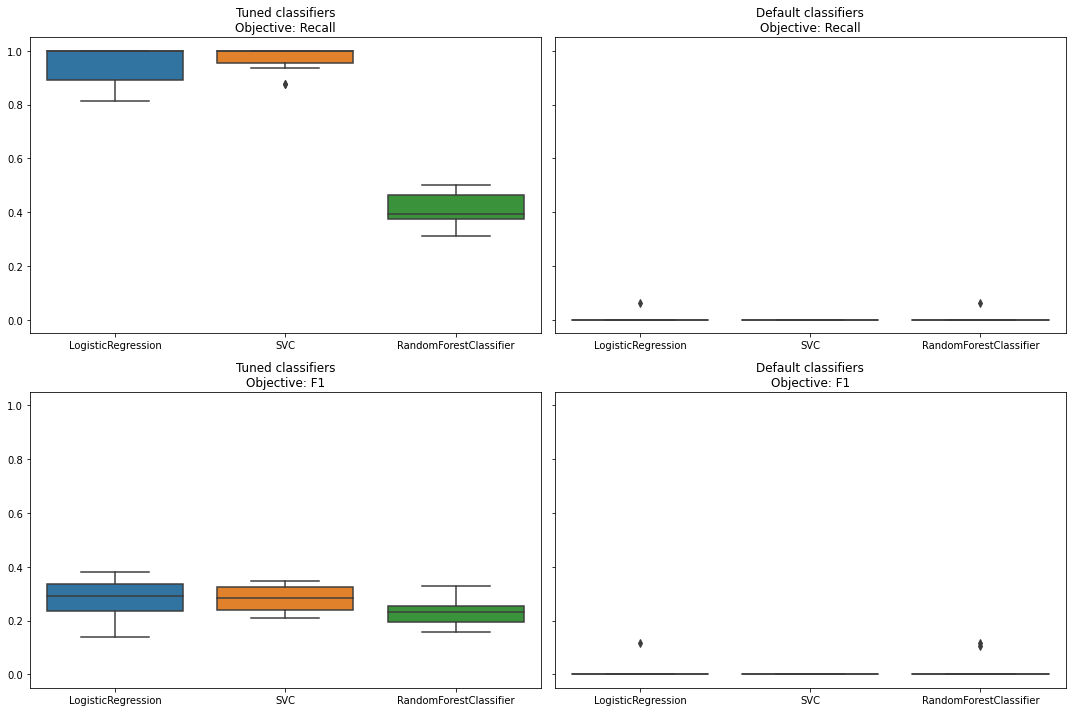


Mean recall and F1-score with standard deviations of default classifiers:



recall                                                f1  \
     LogisticRegression     SVC RandomForestClassifier LogisticRegression   
mean            0.00625 0.00000                0.00625            0.01176   
std             0.01976 0.00000                0.01976            0.03720   

                                     
         SVC RandomForestClassifier  
mean 0.00000                0.02229  
std  0.00000                0.04708


Mean recall and F1-score with standard deviations of tuned classifiers:



recall                                                f1  \
     LogisticRegression     SVC RandomForestClassifier LogisticRegression   
mean            0.94375 0.96875                0.41324            0.27795   
std             0.08042 0.05311                0.06230            0.07788   

                                     
         SVC RandomForestClassifier  
mean 0.28358                0.22859  
std  0.05051                0.04885

In [50]:
# Show tuned and default classifier results

default_scores = pd.DataFrame(joblib.load('results/default_scores'))
tuned_scores = pd.DataFrame(joblib.load('results/tuned_scores'))

fig, axs = plt.subplots(2,2, figsize=(15,10), sharey=True)

sns.boxplot(data=tuned_scores['recall'], ax=axs[0,0])
axs[0,0].set_title('Tuned classifiers\nObjective: Recall')

sns.boxplot(data=tuned_scores['f1'], ax=axs[1,0])
axs[1,0].set_title('Tuned classifiers\nObjective: F1')

sns.boxplot(data=default_scores['recall'], ax=axs[0,1])
axs[0,1].set_title('Default classifiers\nObjective: Recall')

sns.boxplot(data=default_scores['f1'], ax=axs[1,1])
axs[1,1].set_title('Default classifiers\nObjective: F1')

plt.tight_layout()
plt.show()

print('\nMean recall and F1-score with standard deviations of default classifiers:\n')
display(default_scores.agg(['mean', 'std']))

print('\nMean recall and F1-score with standard deviations of tuned classifiers:\n')
display(tuned_scores.agg(['mean', 'std']))

Using both recall and F1 scoring objectives support vector classifier comes out on when cross-validating.

And just to highlight:
* SVC recall: __0.97__
* SVC F1:     __0.28__

## Out-of-sample evaluation

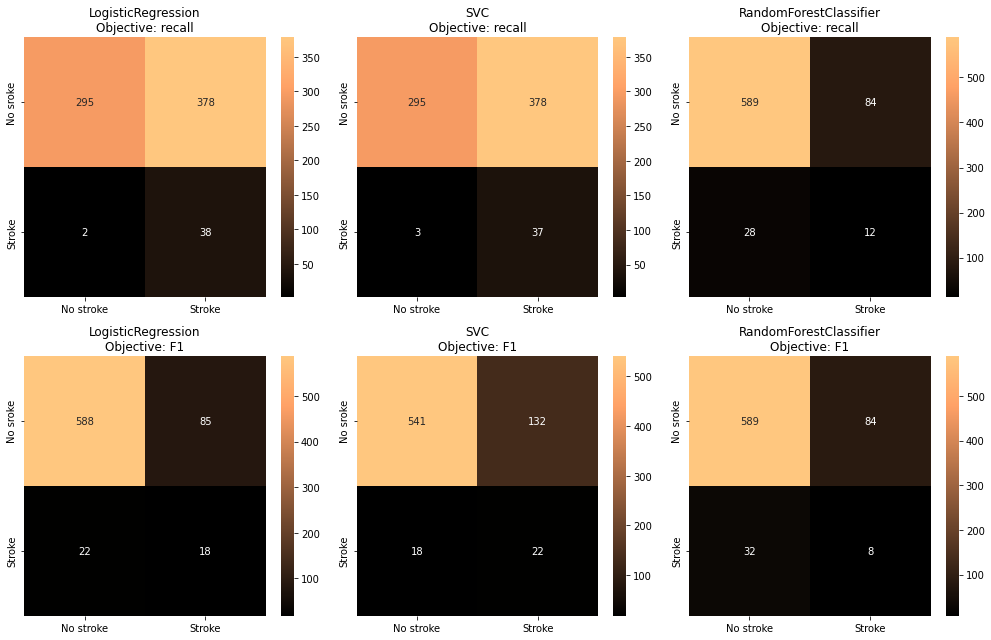

,Objective: recall,Objective: F1,Objective: recall,Objective: F1,Objective: recall,Objective: F1
,LogisticRegression,LogisticRegression,SVC,SVC,RandomForestClassifier,RandomForestClassifier
Recall,0.95000,0.45000,0.92500,0.55000,0.30000,0.20000
F1,0.16667,0.25175,0.16264,0.22680,0.17647,0.12121


In [51]:
# Plot confucion matrices for all classifiers with both objectives

fig, axs = plt.subplots(2,3, figsize=(14,9))

axlist = axs.flatten()

for ax, s, scoring in zip(axlist, searches_recall+searches_f1, [*['recall']*3, *['F1']*3]):
    
    name = s.estimator.named_steps.clf.__class__.__name__
    
    y_pred = s.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, ax=ax, fmt='d', cmap='copper', xticklabels=['No stroke', 'Stroke'], yticklabels=['No sroke', 'Stroke'])
    ax.set_title(f'{name}\nObjective: {scoring}')
    
plt.tight_layout()
plt.show()

scores = {}

# Show recall and F1 score for all six classifiers. Index shows metric, column shows wich objective was used when performing grid search

for s_rec, s_f1 in zip(searches_recall, searches_f1):
    
    name = s_rec.estimator.named_steps.clf.__class__.__name__
    
    y_pred_rec = s_rec.predict(X_test)
    y_pred_f1 = s_f1.predict(X_test)
    
    recall1 = recall_score(y_test, y_pred_rec)
    f11 = f1_score(y_test, y_pred_rec)
    
    recall2 = recall_score(y_test, y_pred_f1)
    f12 = f1_score(y_test, y_pred_f1)
    
    scores[('Objective: recall', name)] = [recall1, f11]
    scores[('Objective: F1', name)] = [recall2, f12]

pd.DataFrame(scores, index=['Recall', 'F1'])

Below are dataframes showing correct and false negative predictions for both recall and F1 objectives.

In [52]:
# Show true positives and false negatives for SVC with objective recall from original dataset

y_pred_rec = pd.DataFrame(searches_recall[1].best_estimator_.predict(X_test))

all_strokes = y_pred_rec[y_test==1]

correctly_predicted_stroke_ids = test_id.loc[all_strokes[all_strokes[0]==1].index]
wrongly_predicted_stroke_ids = test_id.loc[all_strokes[all_strokes[0]==0].index]

print('Objective: Recall\n')

print('True positives')
display(data.loc[data.id.isin(correctly_predicted_stroke_ids)])
print('False negatives')
display(data.loc[data.id.isin(wrongly_predicted_stroke_ids)])

Objective: Recall

True positives


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.00000,0,0,Yes,Self-employed,Rural,202.21000,NaN,never smoked,1
2,31112,Male,80.00000,0,1,Yes,Private,Rural,105.92000,32.50000,never smoked,1
3,60182,Female,49.00000,0,0,Yes,Private,Urban,171.23000,34.40000,smokes,1
6,53882,Male,74.00000,1,1,Yes,Private,Rural,70.09000,27.40000,never smoked,1
11,12095,Female,61.00000,0,1,Yes,Govt_job,Rural,120.46000,36.80000,smokes,1
22,68794,Female,79.00000,0,0,Yes,Self-employed,Urban,228.70000,26.60000,never smoked,1
24,4219,Male,71.00000,0,0,Yes,Private,Urban,102.87000,27.20000,formerly smoked,1
32,39373,Female,82.00000,1,0,Yes,Self-employed,Urban,196.92000,22.20000,never smoked,1
42,61960,Male,82.00000,0,1,Yes,Private,Urban,144.90000,26.40000,smokes,1
44,7937,Male,60.00000,1,0,Yes,Govt_job,Urban,213.03000,20.20000,smokes,1


False negatives


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
39,62602,Female,49.00000,0,0,Yes,Private,Urban,60.91000,29.90000,never smoked,1
41,1261,Male,54.00000,0,0,Yes,Private,Urban,71.22000,28.50000,never smoked,1
210,33943,Female,39.00000,0,0,Yes,Private,Urban,83.24000,26.30000,never smoked,1


In [53]:
# Show true positives and false negatives for SVC with objective F1 from original dataset

y_pred_rec = pd.DataFrame(searches_f1[1].best_estimator_.predict(X_test))

all_strokes = y_pred_rec[y_test==1]

correctly_predicted_stroke_ids = test_id.loc[all_strokes[all_strokes[0]==1].index]
wrongly_predicted_stroke_ids = test_id.loc[all_strokes[all_strokes[0]==0].index]

print('Objective: F1\n')

print('True positives')
display(data.loc[data.id.isin(correctly_predicted_stroke_ids)])
print('False negatives')
display(data.loc[data.id.isin(wrongly_predicted_stroke_ids)])

Objective: F1

True positives


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2,31112,Male,80.00000,0,1,Yes,Private,Rural,105.92000,32.50000,never smoked,1
22,68794,Female,79.00000,0,0,Yes,Self-employed,Urban,228.70000,26.60000,never smoked,1
24,4219,Male,71.00000,0,0,Yes,Private,Urban,102.87000,27.20000,formerly smoked,1
32,39373,Female,82.00000,1,0,Yes,Self-employed,Urban,196.92000,22.20000,never smoked,1
42,61960,Male,82.00000,0,1,Yes,Private,Urban,144.90000,26.40000,smokes,1
56,38829,Female,82.00000,0,0,Yes,Private,Rural,59.32000,33.20000,never smoked,1
57,66400,Male,78.00000,0,0,Yes,Private,Urban,237.75000,NaN,formerly smoked,1
61,55927,Female,80.00000,1,0,Yes,Private,Rural,74.90000,22.20000,never smoked,1
91,51169,Male,81.00000,0,0,Yes,Private,Urban,72.81000,26.30000,never smoked,1
96,35512,Female,70.00000,0,0,Yes,Self-employed,Rural,76.34000,24.40000,formerly smoked,1


False negatives


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.00000,0,0,Yes,Self-employed,Rural,202.21000,NaN,never smoked,1
3,60182,Female,49.00000,0,0,Yes,Private,Urban,171.23000,34.40000,smokes,1
6,53882,Male,74.00000,1,1,Yes,Private,Rural,70.09000,27.40000,never smoked,1
11,12095,Female,61.00000,0,1,Yes,Govt_job,Rural,120.46000,36.80000,smokes,1
39,62602,Female,49.00000,0,0,Yes,Private,Urban,60.91000,29.90000,never smoked,1
41,1261,Male,54.00000,0,0,Yes,Private,Urban,71.22000,28.50000,never smoked,1
44,7937,Male,60.00000,1,0,Yes,Govt_job,Urban,213.03000,20.20000,smokes,1
63,19557,Female,45.00000,0,0,Yes,Private,Rural,93.72000,30.20000,formerly smoked,1
74,19773,Female,52.00000,0,0,Yes,Private,Rural,96.59000,26.40000,never smoked,1
92,66315,Female,57.00000,0,0,No,Self-employed,Urban,68.02000,37.50000,never smoked,1


Just to highlight how each feature contributes to prediction the below plot shows coefficients of logistic regression.

In [54]:
# Get transformed feature names

new_cols = numeric_features + searches_recall[0].best_estimator_.named_steps.col.named_transformers_['cat_processing'][0].get_feature_names_out(categorical_features+binary_features).tolist()

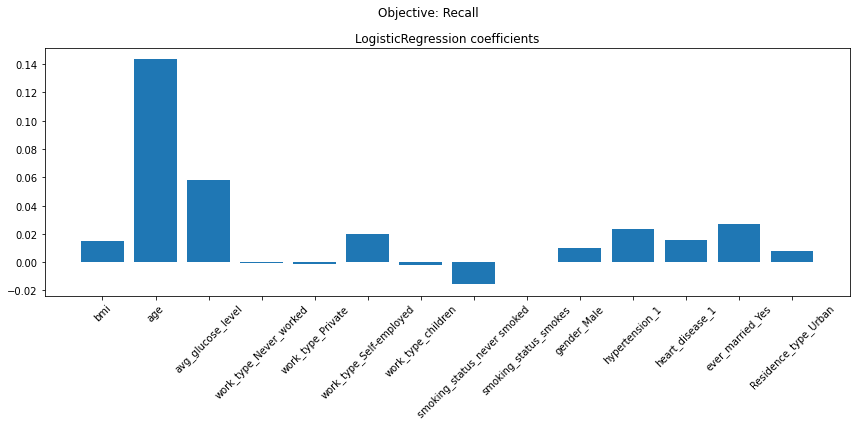

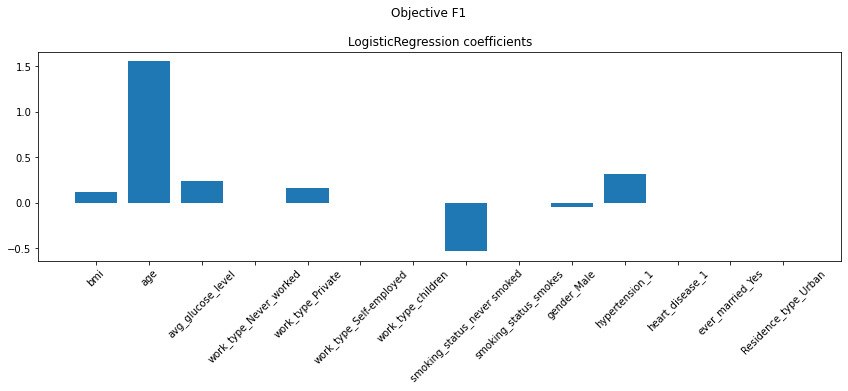

In [55]:
# Plot logistic regression coefficients

fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax1.bar(x=new_cols, height=searches_recall[0].best_estimator_['clf'].coef_[0])
ax1.set_title('LogisticRegression coefficients')
plt.suptitle('Objective: Recall')
plt.xticks(rotation=45)
plt.tight_layout()

fig, ax2 = plt.subplots(1, 1, figsize=(12, 4), sharex=True)
ax2.bar(x=new_cols, height=searches_f1[0].best_estimator_['clf'].coef_[0])
ax2.set_title('LogisticRegression coefficients')
plt.suptitle('Objective F1')
plt.tight_layout()
plt.xticks(rotation=45)

plt.show()

Although I am not a medical expert above plot results seem pretty intuitive. Age and average glucose levels matter the most, if you have not smoked ever it reduces the probability of having a stroke and hypertension (high blood preassure) increases it. Also being married at some time in your life increases the probability which someone __might__ find funny but of course the natural reason for this is that if you are older the chances that you have been married are bigger and as discussed age was the most major factor for predictions at least when using logistic regression.

The takeway is that if we would want to catch every true positive event the number of false positives will become very high. In turn if we want to balance our false negative and false positive predictions the overall performance is not very good either. This comes from the fact that the target is very imbalanced and the underlying features in the dataset are probably not best suited for accurate stroke prediction.

All in all, more data, especially more samples with stroke events, and additional features would be needed for better classification perfomance.